# Evaluating aggregated profiles

We evaluate the well-aggregated profiles by replicate reproducibility via:
1. cytominer-eval package
2. workflow adaped from *https://github.com/jump-cellpainting/workflow_demo_analysis/blob/main/analysis_Broad/0.percent_scores.ipynb*

## Calculate replicate reproducibility

In [1]:
import os
import glob
import gzip
from pathlib import Path

import random
import numpy as np
import pandas as pd
from scipy.special import softmax 

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg

from pycytominer.cyto_utils import infer_cp_features
from cytominer_eval import evaluate
from scripts.utils import calculate_weighted_agg
import scripts.eval_utils as utils


In [2]:
input_folder = 'data/aggregated-profiles/'
results_folder = 'results/'

In [3]:
%%time 

df_list = [pd.read_csv(file, sep='\t') for file in glob.glob(input_folder+'*.tsv')] # for the FULL set of normalized profiles
concat_df = pd.concat(df_list, axis='rows', sort=False)
print(concat_df.shape)

# save the results
# replicate correlation at the guide-level
f_guide_cor_list = []
f_guide_df_list = []
# replicate correlation at the gene-level
f_gene_cor_list = []
f_gene_df_list = []
# method list
method_list = []
# cell_line list
cell_list = []

for method in concat_df.Metadata_agg_method.unique():
    for cell_line in concat_df.Metadata_cell_line.unique():
        print(f"method is {method}, cell line is {cell_line}")
        sub_df = concat_df.query("Metadata_agg_method == @method & Metadata_cell_line == @cell_line")

        # guide-level replicate correlation
        f_guide_cor_val, f_guide_cor_df = evaluate(
            profiles = sub_df,
            features = infer_cp_features(sub_df),
            meta_features = infer_cp_features(sub_df, metadata=True),
            replicate_groups=['Metadata_pert_name', 'Metadata_gene_name', 'Metadata_cell_line', 'Metadata_agg_method'], 
            operation = 'replicate_reproducibility',
            similarity_metric = 'pearson',
        #         replicate_reproducibility_quantile = 0.99,
            replicate_reproducibility_return_median_cor = True
                                  )
        f_guide_cor_list.append(f_guide_cor_val)
        f_guide_df_list.append(f_guide_cor_df)    
    
        # gene-level replicate correlation
        f_gene_cor_val, f_gene_cor_df = evaluate(
            profiles = sub_df,
            features = infer_cp_features(sub_df),
            meta_features = infer_cp_features(sub_df, metadata=True),
            replicate_groups=['Metadata_gene_name', 'Metadata_cell_line', 'Metadata_agg_method'],
            operation = 'replicate_reproducibility',
            similarity_metric = 'pearson',
        #         replicate_reproducibility_quantile= 0.99,
            replicate_reproducibility_return_median_cor = True
                                  )
        f_gene_cor_list.append(f_gene_cor_val)
        f_gene_df_list.append(f_gene_cor_df)
        
        method_list.append(method)
        cell_list.append(cell_line)

guide_rep_cors = pd.concat(f_guide_df_list)
gene_rep_cors = pd.concat(f_gene_df_list)

(5904, 1765)
method is median, cell line is ES2
method is median, cell line is HCC44
method is median, cell line is A549
method is weighted, cell line is ES2
method is weighted, cell line is HCC44
method is weighted, cell line is A549
CPU times: user 4min 22s, sys: 3.02 s, total: 4min 25s
Wall time: 4min 25s


In [4]:
pd.DataFrame(data={'Cell Line': cell_list, 'Aggregation Method': method_list, 
                   'Guide Replicate Reproducibility': f_guide_cor_list, 'Gene Replicate Reproducibility':f_gene_cor_list}).round(4)

,Cell Line,Aggregation Method,Guide Replicate Reproducibility,Gene Replicate Reproducibility
0,ES2,median,0.2441,0.1523
1,HCC44,median,0.2675,0.1605
2,A549,median,0.1698,0.1000
3,ES2,weighted,0.3802,0.2057
4,HCC44,weighted,0.3486,0.1910
5,A549,weighted,0.2721,0.1441


#### quick visualization of well-aggregated profiles

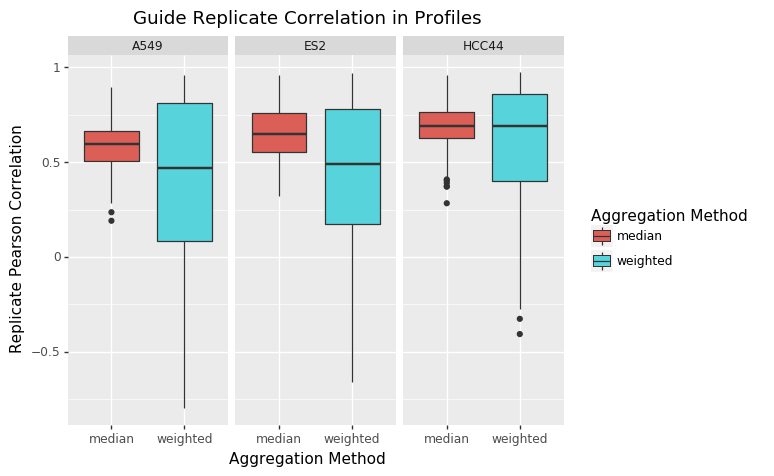

<ggplot: (-9223363248121917454)>

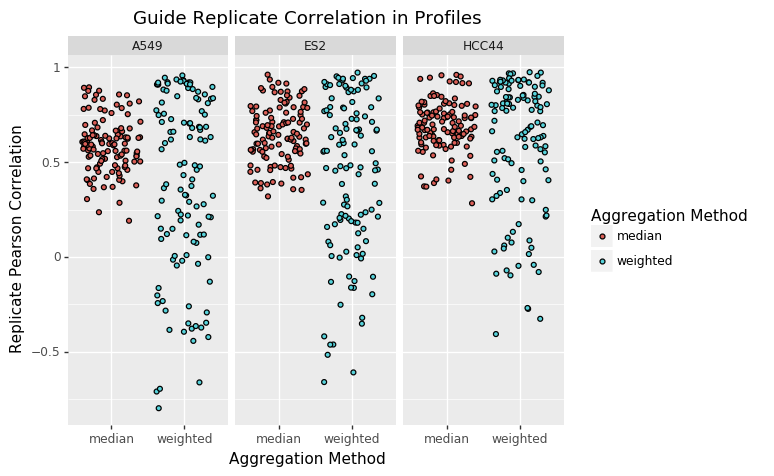

<ggplot: (8788732656795)>

In [5]:
box = (
    gg.ggplot(guide_rep_cors.query("~Metadata_agg_method.str.contains('ctrls')"), gg.aes(fill="Metadata_agg_method", x="Metadata_agg_method", y="similarity_metric"))
    + gg.geom_boxplot()
    + gg.facet_wrap('Metadata_cell_line')
    + gg.labs(title = 'Guide Replicate Correlation in Profiles')
    + gg.labs(x="Aggregation Method", y="Replicate Pearson Correlation", fill="Aggregation Method")
)
display(box)

jitter = (
    gg.ggplot(guide_rep_cors.query("~Metadata_agg_method.str.contains('ctrls')"), gg.aes(fill="Metadata_agg_method", x="Metadata_agg_method", y="similarity_metric"))
    + gg.geom_jitter()
    + gg.facet_wrap('Metadata_cell_line')
    + gg.labs(title = 'Guide Replicate Correlation in Profiles')
    + gg.labs(x="Aggregation Method", y="Replicate Pearson Correlation", fill="Aggregation Method")
)
display(jitter)


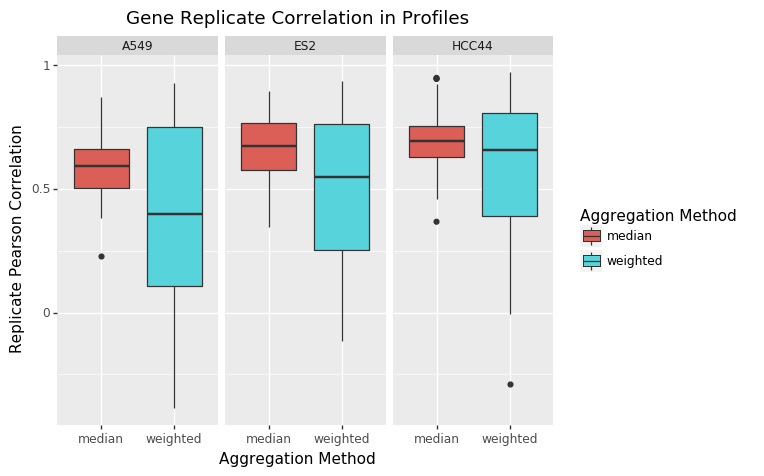

<ggplot: (8788732990177)>

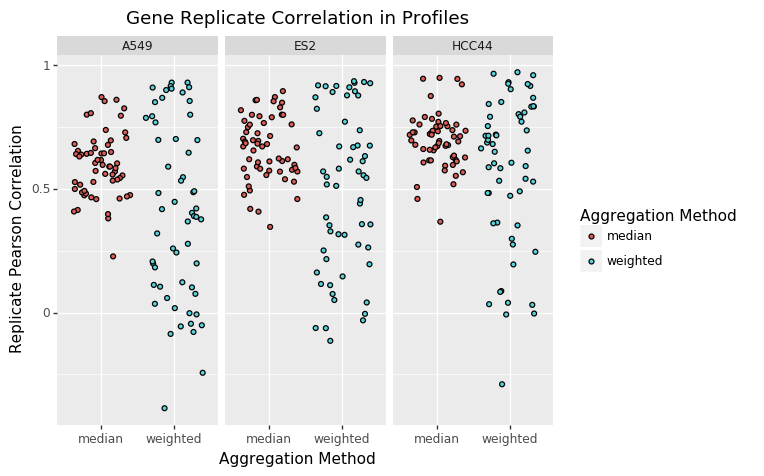

<ggplot: (-9223363248122060393)>

In [6]:
box = (
    gg.ggplot(gene_rep_cors.query("~Metadata_agg_method.str.contains('ctrls')"), gg.aes(fill="Metadata_agg_method", x="Metadata_agg_method", y="similarity_metric"))
    + gg.geom_boxplot()
    + gg.facet_wrap('Metadata_cell_line')
    + gg.labs(title = 'Gene Replicate Correlation in Profiles')
    + gg.labs(x="Aggregation Method", y="Replicate Pearson Correlation", fill="Aggregation Method")
)
display(box)

jitter = (
    gg.ggplot(gene_rep_cors.query("~Metadata_agg_method.str.contains('ctrls')"), gg.aes(fill="Metadata_agg_method", x="Metadata_agg_method", y="similarity_metric"))
    + gg.geom_jitter()
    + gg.facet_wrap('Metadata_cell_line')
    + gg.labs(title = 'Gene Replicate Correlation in Profiles')
    + gg.labs(x="Aggregation Method", y="Replicate Pearson Correlation", fill="Aggregation Method")
)
display(jitter)


#### Save outputs

In [7]:
guide_rep_cors.to_csv(Path(results_folder + "guide_replicate_correlations.tsv"), index=False, sep='\t')
gene_rep_cors.to_csv(Path(results_folder + "gene_replicate_correlations.tsv"), index=False, sep='\t')

## Calculate percent replicating and percent matching
*reference: https://github.com/jump-cellpainting/workflow_demo_analysis/blob/main/analysis_Broad/0.percent_scores.ipynb*

In [8]:
random.seed(9000)

n_samples = 1000 # Number of points to sample from the null distribution.
n_replicates = 6 # Number of replicates of each sample.

replicate_grouping_feature = 'Metadata_pert_name' 
class_grouping_feature = 'Metadata_gene_name' 

### Percent Replicating (previously percent strong)

A "strong signature" is determined by :
1. high pairwise (pearson) correlation w/ each other
2. median replicate correlation is "significantly different" (aka perturbation with median replicate correlation greater than 95th percentile) from null distribution (pairwise correlations of non-replicates)

In [9]:
%%time 

corr_replicating_df = pd.DataFrame()
replicate_corr_list = []
cell_list = []
agg_list = []

for cell_line in concat_df.Metadata_cell_line.unique(): #['ES2']:
    for agg_method in concat_df.Metadata_agg_method.unique(): #['median']: 
        print(f'cell line is \t{cell_line} \naggregation method is \t{agg_method}')
        # Subset for experiment
        sub_df = concat_df.query("Metadata_cell_line == @cell_line & Metadata_agg_method == @agg_method").dropna(axis='columns')

        print(f'The combined experiment has {sub_df.shape[0]} wells and {sub_df.shape[1]} features')

        # Remove empty wells and negative controls
        compound_df = sub_df.query("Metadata_gene_name != 'Chr2'")

        # Calculate list of correlations for replicates
        replicate_corr_df = utils.corr_between_replicates(compound_df,
                                                    replicate_grouping_feature)

        # Calculate list of correlations for non-replicates 
        null_replicate_corr = list(utils.corr_between_non_replicates(compound_df,
                                                               n_samples,
                                                               n_replicates,
                                                               replicate_grouping_feature))

        # Calculate the percent score (% of replicates above 95th %ile of null)
        prop_95_replicating, value_95_replicating = utils.percent_score(null_replicate_corr,
                                                                  replicate_corr_df.correlation,
                                                                  how='right')

        corr_replicating_df = corr_replicating_df.append({'Experiment':f'{cell_line} {agg_method} plates',
                                                          'Replicate_corr':list(replicate_corr_df.correlation),
                                                          'Null_corr':null_replicate_corr,
                                                          'Percent_Replicating':'%.3f'%prop_95_replicating,
                                                          'Value_95':value_95_replicating}, ignore_index=True)


        cell_list.append(cell_line)
        agg_list.append(agg_method)

cell line is 	ES2 
aggregation method is 	median
The combined experiment has 984 wells and 1731 features
cell line is 	ES2 
aggregation method is 	weighted
The combined experiment has 984 wells and 1731 features
cell line is 	HCC44 
aggregation method is 	median
The combined experiment has 984 wells and 1719 features
cell line is 	HCC44 
aggregation method is 	weighted
The combined experiment has 984 wells and 1719 features
cell line is 	A549 
aggregation method is 	median
The combined experiment has 984 wells and 1751 features
cell line is 	A549 
aggregation method is 	weighted
The combined experiment has 984 wells and 1751 features
CPU times: user 42.5 s, sys: 131 ms, total: 42.7 s
Wall time: 42.7 s


In [10]:
display(corr_replicating_df)

,Experiment,Null_corr,Percent_Replicating,Replicate_corr,Value_95
0,ES2 median plates,"[0.180845076250728, 0.5308219840803317, 0.2058...",0.625,"[0.5973352365938563, 0.5684542749248489, 0.622...",0.614689
1,ES2 weighted plates,"[-0.3874697135488868, 0.024678471290850577, 0....",0.607,"[0.050807259598664334, 0.18136109203030223, 0....",0.389789
2,HCC44 median plates,"[0.613138408969547, 0.32197569282171024, 0.358...",0.679,"[0.6166827700702135, 0.6521944680575164, 0.591...",0.649704
3,HCC44 weighted plates,"[-0.18368280545556603, -0.11760750850047931, 0...",0.616,"[0.8155205649089808, -0.4066895085799368, 0.84...",0.610244
4,A549 median plates,"[0.4141561173086472, 0.4409969187743149, 0.404...",0.420,"[0.5286342235265379, 0.5339082704648461, 0.459...",0.621783
5,A549 weighted plates,"[-0.3091651651535289, 0.055988767346546134, 0....",0.393,"[-0.3469551610951277, 0.14920425576519147, 0.1...",0.682522


### Percent Matching (previously percent recall)

Percent Matching is similar to Percent Replicating, but instead of pairwise correlations between replicates, we calculate the pairwise correlations between a pair of compounds that have the same MOA annotation or have been known to target the same gene. 

In this case, the null distribution is constructed from the pairwise correlations of compounds that belong to different MOA classes or target different genes.


In [11]:
%%time 

corr_matching_df = pd.DataFrame()
cell_list = []
agg_list = []

for cell_line in concat_df.Metadata_cell_line.unique(): #['ES2']:
    for agg_method in concat_df.Metadata_agg_method.unique(): #['median']:
        print(f'cell line is \t{cell_line} \naggregation method is \t{agg_method}')
        # Subset for experiment
        sub_df = concat_df.query("Metadata_cell_line == @cell_line & Metadata_agg_method == @agg_method").dropna(axis='columns')

        print(f'The combined experiment has {sub_df.shape[0]} wells and {sub_df.shape[1]} features')

        # Remove empty wells and negative controls
        compound_df = sub_df.query("Metadata_gene_name != 'Chr2'")
        
        # Calculate list of correlations for pairs 
        matching_corr = list(utils.corr_between_perturbation_pairs(compound_df,
                                                                   class_grouping_feature,
                                                                   replicate_grouping_feature))


        # Calculate list of corremations for non-pairs
        null_matching = list(utils.corr_between_perturbation_non_pairs(compound_df,
                                                                       n_samples,
                                                                       class_grouping_feature,
                                                                       replicate_grouping_feature))
        
        
        # Calculate the percent score (% of replicates above 95th %ile of null)
        prop_95_matching, value_95_matching = utils.percent_score(null_matching,
                                                                  matching_corr,
                                                                  how='right')


        corr_matching_df = corr_matching_df.append({'Experiment':f'{cell_line} {agg_method} plates',
                                                    'Matching_corr':matching_corr,
                                                    'Null_Matching':null_matching,
                                                    'Percent_Matching':'%.3f'%prop_95_matching,
                                                    'Value_95':value_95_matching}, ignore_index=True)

        cell_list.append(cell_line)
        agg_list.append(agg_method)

cell line is 	ES2 
aggregation method is 	median
The combined experiment has 984 wells and 1731 features
cell line is 	ES2 
aggregation method is 	weighted
The combined experiment has 984 wells and 1731 features
cell line is 	HCC44 
aggregation method is 	median
The combined experiment has 984 wells and 1719 features
cell line is 	HCC44 
aggregation method is 	weighted
The combined experiment has 984 wells and 1719 features
cell line is 	A549 
aggregation method is 	median
The combined experiment has 984 wells and 1751 features
cell line is 	A549 
aggregation method is 	weighted
The combined experiment has 984 wells and 1751 features
CPU times: user 15 s, sys: 11.9 ms, total: 15 s
Wall time: 15 s


In [12]:
display(corr_matching_df)

,Experiment,Matching_corr,Null_Matching,Percent_Matching,Value_95
0,ES2 median plates,"[0.5908634024934774, 0.6639817986463066, 0.610...","[0.11060964078364688, 0.6646427938991752, 0.51...",0.481,0.677895
1,ES2 weighted plates,"[0.39124580573835555, -0.21451698647638737, 0....","[0.10170255353395899, 0.4892367443967581, -0.1...",0.288,0.757849
2,HCC44 median plates,"[0.7050695028361944, 0.6085093988585528, 0.383...","[0.6166331728020491, 0.6012910696269549, 0.432...",0.212,0.754744
3,HCC44 weighted plates,"[0.32708211549805044, 0.6107374448135969, -0.4...","[-0.24729875030492404, 0.8088911386936168, -0....",0.192,0.819521
4,A549 median plates,"[0.5167114135609996, 0.5613826684140573, 0.861...","[0.5350069219620248, 0.425930338091137, 0.1436...",0.288,0.668776
5,A549 weighted plates,"[0.28537725795196534, 0.18881355815338896, 0.9...","[0.23838957758927715, -0.3855181417905913, -0....",0.154,0.848509


In [13]:
guide_sub = corr_replicating_df.drop(columns=['Null_corr', 'Replicate_corr'], axis='columns', inplace=False)
gene_sub = corr_matching_df.drop(columns=['Matching_corr', 'Null_Matching', ], axis='columns', inplace=False)
merged_df = pd.merge(guide_sub, gene_sub, how='inner', on='Experiment')
merged_df[['Cell Line', 'Aggregation Method']] = merged_df.Experiment.str.split(' ', expand=True).loc[:,0:1]
merged_df[['Cell Line', 'Aggregation Method', 
           'Percent_Replicating', 'Value_95_x', 'Percent_Matching', 'Value_95_y']].sort_values("Aggregation Method")

,Cell Line,Aggregation Method,Percent_Replicating,Value_95_x,Percent_Matching,Value_95_y
0,ES2,median,0.625,0.614689,0.481,0.677895
2,HCC44,median,0.679,0.649704,0.212,0.754744
4,A549,median,0.420,0.621783,0.288,0.668776
1,ES2,weighted,0.607,0.389789,0.288,0.757849
3,HCC44,weighted,0.616,0.610244,0.192,0.819521
5,A549,weighted,0.393,0.682522,0.154,0.848509


#### Save outputs

In [14]:
corr_replicating_df.to_csv(Path(results_folder + "percent_replicating.tsv"), index=False, sep='\t')
corr_matching_df.to_csv(Path(results_folder + "percent_matching.tsv"), index=False, sep='\t')